# Данные

In [1]:
import pandas as pd
df = pd.read_csv('vk_texts_with_sources.csv', usecols = ['text', 'source'])
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


# Домашнее задание 1 

В этом домашнем задании вы будете решать задачу тематической классификации. Даны тексты, опубликованные в нескольких пабликах VK.com, посвященных государственным и муниципальным службам. Формально задача заключается в том, чтобы по тексту ($d$) определить в каком паблике он опубликован, то есть, к какому классу $c$ он принадлежит. 

In [2]:
from os import path
from string import punctuation
from collections import Counter, defaultdict
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from scipy import sparse
import numpy as np
import fasttext as ft

import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim as gensimvis
import pyLDAvis

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from gensim.corpora import *
from gensim.models import  *
#from gensim.models import Doc2Vec
#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

c:\python35\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Задание 1 [2 балла]. Описательные статистики
Посчитайте:
* количество текстов и количество классов
* количество слов (без лемматизации и с лемматизацией) в коллекции
* среднюю длину текста в словах и символах
* найдите 5 самых частых существительных в текстах каждого паблика 

*Рекомендуем использовать pandas для расчета описательных статистик.*

Разделите коллекцию текстов на обучающую и тестовую части. 

In [3]:
df = df.dropna() #удаляем NaN
df = df.reset_index(drop=True) #переназначаем индексы

In [4]:
texts = len(df) #длина датафрейма = кол-во текстов
texts

11526

In [5]:
classes = len(df.source.unique()) #число уникальных значений в столбце source = кол-во классов
classes

4

In [6]:
#делим строки по пробелам и суммируем токены, суммируем эти значения = кол-во слов
words = sum(df['text'].str.split().str.len())
words

981499

In [7]:
#из них уникальных слов
words_unique = set()
df['text'].str.lower().str.split().apply(words_unique.update)
len(words_unique)

131279

In [4]:
#решила помимо лемматизации сразу сделать предобработку:
#удаляем пунктуацию, приводим к нижнему регистру, удаляем стоп слова, приводим слова к нормальной форме, убираем тег

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№#–<>'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in str(text).lower().split()]
    words = [morph.parse(word)[0] for word in words if word and word not in stops]
    words = [word.normal_form for word in words]
    words = [word.replace('br','') for word in words]

    return words

In [5]:
df['text_norm'] = df['text'].apply(normalize)

In [6]:
df['text_norm'] = df['text_norm'].apply(' '.join)
df['text_norm'].head(10)

0    начальник главный оперативный управление генер...
1    артиллерийский подразделение общевойсковой объ...
2    подразделение морской пехота каспийский флотил...
3    команда всеармейский этап конкурс арми-2018 та...
4    большой учебно-методический командирский сбор ...
5    моряк отряд корабль тихоокеанский флот состав ...
6    военнослужащие–женщина бронеавтомобиль продемо...
7    один старый аэродром европа девау калининградс...
8    баренцев мор начаться учение разнородный сила ...
9    экипаж самолёт морской авиация черноморский фл...
Name: text_norm, dtype: object

In [11]:
#кол-во слов после препроцессинга
words_norm = sum(df['text_norm'].str.split().str.len())
words_norm

763859

In [12]:
#уникальных слов
words_norm_unique = set()
df['text_norm'].str.lower().str.split().apply(words_norm_unique.update)
len(words_norm_unique)

52461

In [13]:
#средняя длина текста в словах
mean_words = words/texts
int(mean_words)

85

In [14]:
#средняя длина в символах
chars = sum(df['text'].str.len())
mean_chars = chars/texts
int(mean_chars)

690

In [15]:
#5 наиболее частотных слов по всей коллекции (не считая "который")
Counter(' '.join(df['text_norm']).split()).most_common(6) 

[('россия', 9423),
 ('год', 9039),
 ('полиция', 5929),
 ('москва', 5048),
 ('который', 4318),
 ('мвд', 4047)]

In [16]:
#какие есть классы и как распределены
df['source'].value_counts()

mchsgov        3024
mil            3017
mospolice      2854
russianpost    2631
Name: source, dtype: int64

In [17]:
#добавляем к нормализации условие про часть речи, еще заменила штуку, которая не убралась на предыдущих шагах
def postagging(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0] for word in words if word and word not in stops]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN']
    words = [word.replace('br','') for word in words]
    words = [word.replace('>#', '') for word in words] 
    
    return words

In [18]:
#оставляем только существительные
df['text_nouns'] = df['text'].apply(postagging)

In [19]:
df['text_nouns'] = df['text_nouns'].apply(' '.join)
df['text_nouns'].head(10)

0    начальник управление штаб сила рф генерал-полк...
1    подразделение объединение край кубань период о...
2    подразделение пехота флотилия новое бронетранс...
3    команда этап конкурс биатлон натиск область ум...
4    сбор полигон сибирь цель вал приём время опера...
5    моряк отряд корабль флот состав корабль адмира...
6    военнослужащие–женщина бронеавтомобиль автошоу...
7    аэродром европа девау область течение день фес...
8    мор учение сила флот участие слушатель академи...
9    экипаж самолёт авиация флот поиск уничтожение ...
Name: text_nouns, dtype: object

In [20]:
#наиболее частотные сущ класса mchsgov: даём series в индекс последовательность true/false, если true то вкл. элемент
#решила взять 7 т.к. "россия" и "год" частотные для всех, это пригодится для правил
bool_indices_mch = (df['source'] == 'mchsgov')
mchsgov = df['text_nouns'][bool_indices_mch]

Counter(' '.join(mchsgov).split()).most_common(7)

[('мчс', 3446),
 ('россия', 1592),
 ('мчсроссия', 1209),
 ('спасатель', 564),
 ('год', 504),
 ('человек', 429),
 ('помощь', 415)]

In [21]:
#наиболее частотные сущ класса mil (подозреваю, что военный тут не|не всегда существительное)
bool_indices_mil = (df['source'] == 'mil')
mil = df['text_nouns'][bool_indices_mil]

Counter(' '.join(mil).split()).most_common(7)

[('военный', 1353),
 ('россия', 1280),
 ('год', 1264),
 ('минобороны', 1255),
 ('оборона', 912),
 ('учение', 862),
 ('сила', 786)]

In [22]:
#наиболее частотные сущ класса mospolice
bool_indices_mospolice = (df['source'] == 'mospolice')
mospolice = df['text_nouns'][bool_indices_mospolice]

Counter(' '.join(mospolice).split()).most_common(7)

[('полиция', 5745),
 ('год', 5201),
 ('москва', 4157),
 ('мвд', 4051),
 ('россия', 3976),
 ('сотрудник', 2492),
 ('увд', 1644)]

In [23]:
#наиболее частотные суш класса russianpost
bool_indices_russianpost = (df['source'] == 'russianpost')
russianpost = df['text_nouns'][bool_indices_russianpost]

Counter(' '.join(russianpost).split()).most_common(7)

[('почта', 3113),
 ('россия', 2575),
 ('год', 2070),
 ('отделение', 1577),
 ('письмо', 1442),
 ('открытка', 1302),
 ('марка', 1288)]

In [24]:
#разделим исходные данные без каких-либо преобразований на обучающее и тестовое множества (80/20), предварительно перемешав

#data = df[['text','source']]
data = shuffle(df)

train, test = train_test_split(data, test_size=0.2)
train.tail()

,text,source,text_norm,text_nouns
10850,Полицейские САО задержали подозреваемого в огр...,mospolice,полицейский сао задержать подозревать ограблен...,полицейский ограбление курьер ><>https://www.y...
424,Сегодня исполнилось 100 лет со дня образования...,mil,сегодня исполниться 100 год день образование с...,год день образование система оборона москва пе...
1918,В учебном центре инженерных войск проведены та...,mil,учебный центр инженерный войско провести такти...,центр войско занятие вожатый собака служба пит...
186,Съемочная группа программы «Военная приемка» о...,mil,съёмочный группа программа военный приёмка отп...,группа программа приёмка страна азия мьянма се...
3080,#МЧС #МЧСРОССИИ <br><br>Владимир Пучков наград...,mchsgov,мчс мчсроссия ><>владимир пучок наградить учас...,мчс мчсроссия ><>владимир пучок участник экспе...


 ## Задание 2 [2 балла]. Классификация по правилам
 
 * Разработайте несколько правил вида "Если встречается слово $w$, то текст относится к паблику $c$"
 * Посчитайте, какую точность, полноту, $f$-меру и $accuracy$ вы получаете при классификации по правилам
 * Получилось ли у вас придумать правило, которое никогда не ошибается?

Т.к. как минимум во всех текстах самые частотные слова - россия и год, я сначала решила не включать их в топ для отдельного класса, потом отдать россию мчс, а год милу, поскольку оставались неклассифицированные тексты, а другие два и так нормально предсказывались, это помогло второму, а первому не очень, поэтому я второму добавила слов и просто изначально задала все классы как мчс и кстати это сработало ¯\_(ツ)_/¯.

In [25]:
df_true = df[['text_norm','source']]
df_train = df[['text_norm']]

In [26]:
#почта и полиция идут после и, кажется, "забирали" классы у mil и мчс + некоторые тексты вообще не классифицировались,
#поэтому взяла больше частотных слов для первых двух, а у полиции убрала "москву" и "сотрудника", изначаль задала всем mchsgov

top_mchsgov = ['мчс', 'мчсроссия', 'спасатель', 'человек', 'помощь', 'безопасность','работа','пожар', 'россия']
top_mil = ['военный', 'минобороны', 'оборона', 'учение', 'сила', 'ход', 'время', 'корабль', 'год', 'флот', 'комплекс']
top_mospolice = ['полиция', 'мвд', 'увд']
top_russianpost = ['почта', 'отделение', 'письмо', 'открытка', 'марка']

In [27]:
#создаем новый столбик, создаем столбик с булевыми значениями, приписываем класс если True = если есть пересечение
#множества слов текста и множества топ-слов

def classification(data, df):
    
    df['source'] = 'mchsgov'
    
    bools_mchs = data.apply(lambda x: len(set(x.split()).intersection(set(top_mchsgov))) > 0)
    df['source'][bools_mchs] = 'mchsgov'
    
    bools_mil = data.apply(lambda x: len(set(x.split()).intersection(set(top_mil))) > 0)
    df['source'][bools_mil] = 'mil'
    
    bools_police = data.apply(lambda x: len(set(x.split()).intersection(set(top_mospolice))) > 0)
    df['source'][bools_police] = 'mospolice'
    
    bools_post = data.apply(lambda x: len(set(x.split()).intersection(set(top_russianpost))) > 0)
    df['source'][bools_post] = 'russianpost'
    
    return df

In [28]:
#классифицируем
df_train = classification(df_train['text_norm'], df_train)

c:\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\python35\lib\site-packages\pandas\core\generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
c:\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
#сколько получилось слов в результате
df_train['source'].value_counts()

mchsgov        3173
mil            3114
mospolice      2714
russianpost    2525
Name: source, dtype: int64

In [30]:
#сравним с правильным распределением
df['source'].value_counts()

mchsgov        3024
mil            3017
mospolice      2854
russianpost    2631
Name: source, dtype: int64

Уже без метрик видно, что идеальных правил нет, но с некоторыми ухищрениями, описанными выше, удалось сделать перекосы по числу слов не такими большими. Посмотрим на метрики.

In [31]:
labels = ['mchsgov', 'mil', 'mospolice', 'russianpost']

In [32]:
def evaluation(y_true, y_pred):
    rprt = classification_report(y_true, y_pred, labels = labels)
    print(rprt)
    print()
    
    acc = accuracy_score(y_true, y_pred)
    print('Accuracy = ', acc)
    

In [33]:
evaluation(df_true['source'], df_train['source'])

              precision    recall  f1-score   support

     mchsgov       0.70      0.74      0.72      3024
         mil       0.73      0.76      0.75      3017
   mospolice       0.95      0.90      0.93      2854
 russianpost       0.87      0.84      0.85      2631

   micro avg       0.81      0.81      0.81     11526
   macro avg       0.82      0.81      0.81     11526
weighted avg       0.81      0.81      0.81     11526


Accuracy =  0.8069581815026896


Неплохо для правил!

## Задание 3 [4 балла]. Baseline
Используйте стандартный ```sklearn.pipeline``` для классификации текстов: 
* векторизация 
* $tf-idf$ взвешивание 
* ваш любимый метод классификации.


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [35]:
vectorizer = CountVectorizer(ngram_range=(1,1))  
tfidf = TfidfTransformer()  
classifier = SGDClassifier()  #попробовала разные, лучшие показатели были у него

clf = Pipeline([
    ('vect', vectorizer),
    ('tf-idf', tfidf),
    ('clf', classifier),
])

clf.fit(train.text, train.source)  

c:\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [36]:
predictions = clf.predict(test.text)

In [37]:
evaluation(test.source, predictions)

              precision    recall  f1-score   support

     mchsgov       0.99      0.97      0.98       618
         mil       1.00      0.99      0.99       630
   mospolice       0.97      0.99      0.98       555
 russianpost       0.95      0.96      0.95       503

   micro avg       0.98      0.98      0.98      2306
   macro avg       0.98      0.98      0.98      2306
weighted avg       0.98      0.98      0.98      2306


Accuracy =  0.9774501300954033


Результаты хорошо превзошли подход, основанный на правилах, визуализируем их.

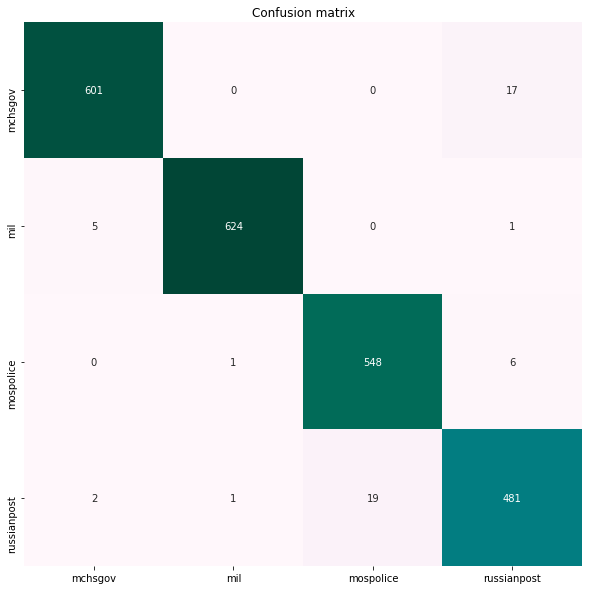

In [38]:
m = confusion_matrix(test.source, predictions)

#labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Лучшие результаты у класса mil, немножко перепутан mchsgov с mil, при построении правил тоже было это заметно, скорее всего из-за россии, но в почте тоже она на втором месте, возможно поэтому она определялась как мчс + например, _работа, человек_; а полиция и почта, наверное, иногда были классифицированы неверно, потому что и там, и там есть отделения....

## Задание 4 [2 балла]. Снижение размерности
Добавьте в ваш ```sklearn.pipeline```  методы снижения размерности:  PCA / LSI / LSA / LDA / другое. Какие методы классификации разумно использовать после снижения размерности? Как изменились результаты классификации после добавления нового шага?

In [39]:
vectorizer = CountVectorizer(ngram_range=(1,1))
tfidf = TfidfTransformer()
lsa = TruncatedSVD()
classifier = GradientBoostingClassifier()

clf = Pipeline([
    ('vect', vectorizer),
    ('tf-idf', tfidf),
    ('red_dim', lsa),
    ('norm', StandardScaler()),
])

X = clf.fit_transform(train.text)
classifier.fit(X, train.source)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [40]:
y = clf.fit_transform(test.text)

predictions = classifier.predict(y)

In [41]:
evaluation(test.source, predictions)

              precision    recall  f1-score   support

     mchsgov       0.88      0.88      0.88       618
         mil       0.66      0.66      0.66       630
   mospolice       0.83      0.94      0.88       555
 russianpost       0.55      0.48      0.51       503

   micro avg       0.75      0.75      0.75      2306
   macro avg       0.73      0.74      0.73      2306
weighted avg       0.74      0.75      0.74      2306


Accuracy =  0.7458803122289679


Качество сильно ухудшилось, так как после снижения размерности нужно еще применять нормализацию, стало более-менее, когда использовала StandardScaler и заменила классификатор на градиентный бустинг, так вышло чуть лучше, чем с SGD, получается перепутанными классы mil и russianpost.

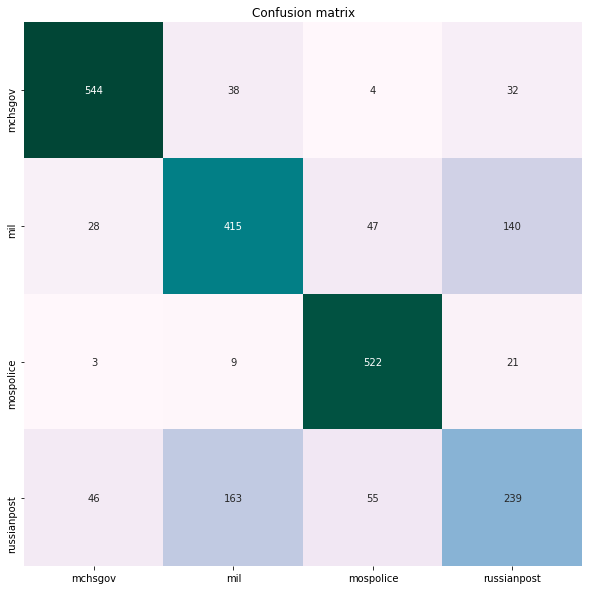

In [42]:
m = confusion_matrix(test.source, predictions)

#labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Задание 5 [2 балла]. Лемматизация
Посмотрите, как влияет лемматизация на качество классификации. Как изменится качество классификации, если вы используете ```CountVectorizer``` на словах или $n$-граммах на лемматизированных текстах?

Проделаем то же самое со столбцом text_norm, содержащим тексты после предобработки.

In [43]:
vectorizer = CountVectorizer(ngram_range=(1,1))
tfidf = TfidfTransformer()
classifier = SGDClassifier()

clf = Pipeline([
    ('vect', vectorizer),
    ('tf-idf', tfidf),
    ('clf', classifier),
])

clf.fit(train.text_norm, train.source)

c:\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [44]:
predictions = clf.predict(test.text_norm)

In [45]:
evaluation(test.source, predictions)

              precision    recall  f1-score   support

     mchsgov       0.99      0.97      0.98       618
         mil       0.99      0.99      0.99       630
   mospolice       0.96      0.99      0.98       555
 russianpost       0.96      0.95      0.95       503

   micro avg       0.98      0.98      0.98      2306
   macro avg       0.98      0.98      0.98      2306
weighted avg       0.98      0.98      0.98      2306


Accuracy =  0.9765828274067649


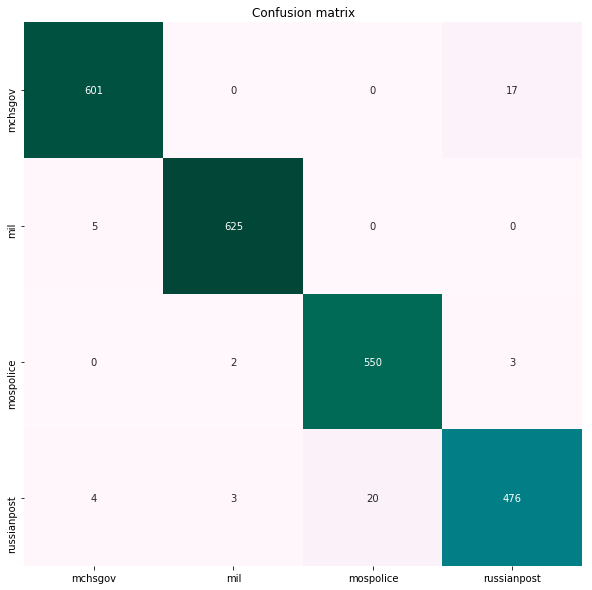

In [46]:
m = confusion_matrix(test.source, predictions)

#labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

После обучения на нормализованных текстах качество не сильно меняется, +- 0.01 к ф-мерам отдельных классов.

In [47]:
vectorizer = CountVectorizer(ngram_range=(1,2))  #добавляем n-граммы
tfidf = TfidfTransformer()
classifier = SGDClassifier()

clf = Pipeline([
    ('vect', vectorizer),
    ('tf-idf', tfidf),
    ('clf', classifier),
])

clf.fit(train.text_norm, train.source)

c:\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [48]:
predictions = clf.predict(test.text_norm)

In [49]:
evaluation(test.source, predictions)

              precision    recall  f1-score   support

     mchsgov       0.99      0.97      0.98       618
         mil       0.99      0.99      0.99       630
   mospolice       0.97      0.99      0.98       555
 russianpost       0.96      0.96      0.96       503

   micro avg       0.98      0.98      0.98      2306
   macro avg       0.98      0.98      0.98      2306
weighted avg       0.98      0.98      0.98      2306


Accuracy =  0.9791847354726799


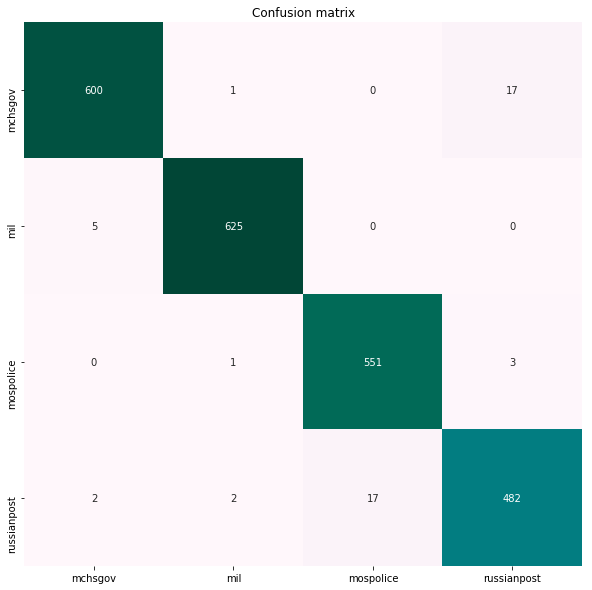

In [50]:
m = confusion_matrix(test.source, predictions)

#labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

После применения биграм, на разных итерация ф-меры отдельных классов прибавляли 0.01, увеличивалась accuracy на 0.01 и precision-mil recall-mospolice были 1.00, при n>2 дальнейших изменений не происходило.

## Задание 6 [4 балла]. Модель скрытых тем
Постройте и визуализируйте модель скрытых тем (LSI или LDA) по данной коллекции текстов. Нужно ли здесь использовать разделение на тестовую и обучающую части? **Нет** Как модель скрытых тем может помочь в решении задачи классификации? **Они используются для снижения размерности матрицы признаков**.

Представим данные словарем и корпусом в Gensim:

In [51]:
texts = [df.text_norm.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Вычислим сходства по косинусной мере на векторах $tf-idf$:

In [52]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

**Латентно-семантический анализ**

In [53]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4)

In [54]:
lsi.show_topics()

[(0,
  '0.233*"полиция" + 0.218*"мвд" + 0.188*"москва" + 0.177*"год" + 0.149*"гу" + 0.148*"задержать" + 0.146*"россия" + 0.134*"петровка38" + 0.124*"сотрудник" + 0.122*"подозревать"'),
 (1,
  '0.540*"мчс" + 0.529*"мчсроссия" + 0.214*"советмчс" + 0.206*"безопасностьэтый" + 0.189*"фактмчс" + 0.171*"следовать" + 0.160*"><>бережать" + 0.144*"правило" + 0.143*"безопасность" + -0.111*"полиция"'),
 (2,
  '-0.206*"мчсроссия" + 0.163*"почтовый" + -0.155*"мчс" + -0.155*"мвд" + -0.154*"полиция" + 0.141*"почта" + -0.136*"задержать" + -0.124*"петровка38" + 0.119*"военный" + -0.119*"подозревать"'),
 (3,
  '-0.239*"утро" + 0.238*"задержать" + -0.235*"хороший" + -0.227*"успешный" + -0.219*"добрый" + -0.215*"понедельник" + -0.203*"рабочий" + 0.199*"подозревать" + -0.198*">фото" + -0.182*"неделя"')]

Главные компоненты

In [55]:
X = [0] * len(df)
Y = [0] * len(df)
for i in range(len(df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    try:
        for topic in LSI_topics:
            if topic[0] == 0:
                X[i] = topic[1]
            elif topic[0] == 1:
                Y[i] = topic[1]
    except:
        pass
vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : df.source})

c:\python35\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


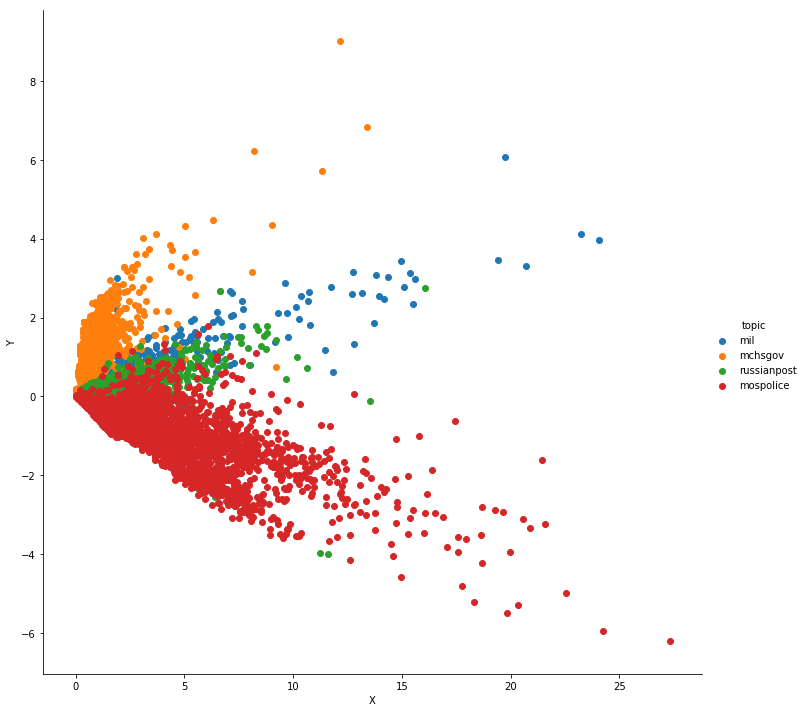

In [56]:
sns.FacetGrid(vis_df, hue="topic", size = 10).map(plt.scatter, "X", "Y").add_legend()

**Латентное размещение Дирихле**

In [57]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4)

In [58]:
lda.show_topics()

[(0,
  '0.014*"год" + 0.007*"конкурс" + 0.005*"россия" + 0.004*"который" + 0.004*"также" + 0.004*"университет" + 0.004*"соревнование" + 0.003*"почтовый" + 0.003*"один" + 0.003*"пройти"'),
 (1,
  '0.017*"россия" + 0.017*"год" + 0.014*"полиция" + 0.012*"москва" + 0.011*"мвд" + 0.007*"сотрудник" + 0.007*"который" + 0.007*"новость" + 0.006*"почтовый" + 0.006*"почта"'),
 (2,
  '0.023*"гу" + 0.023*"полиция" + 0.018*"москва" + 0.018*"год" + 0.013*"петровка38" + 0.012*"россия" + 0.011*"увд" + 0.010*"мвд" + 0.009*"сотрудник" + 0.007*"служба"'),
 (3,
  '0.026*"задержать" + 0.025*"уголовный" + 0.013*"петровка38" + 0.011*"полиция" + 0.010*"средство" + 0.007*"возбудить" + 0.007*">ть" + 0.007*"район" + 0.006*"ход" + 0.006*"изъять"')]

In [59]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Попробуем просто применить LSA и визуализировать с помощью t-distributed stochastic neighbor embedding (TSNE)

In [60]:
vectors = TfidfVectorizer().fit_transform(df.text_norm)
X_reduced = TruncatedSVD(n_components=150, random_state=0).fit_transform(vectors)
X_embedded = TSNE(n_components=2, perplexity=100, verbose=0).fit_transform(X_reduced)

c:\python35\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


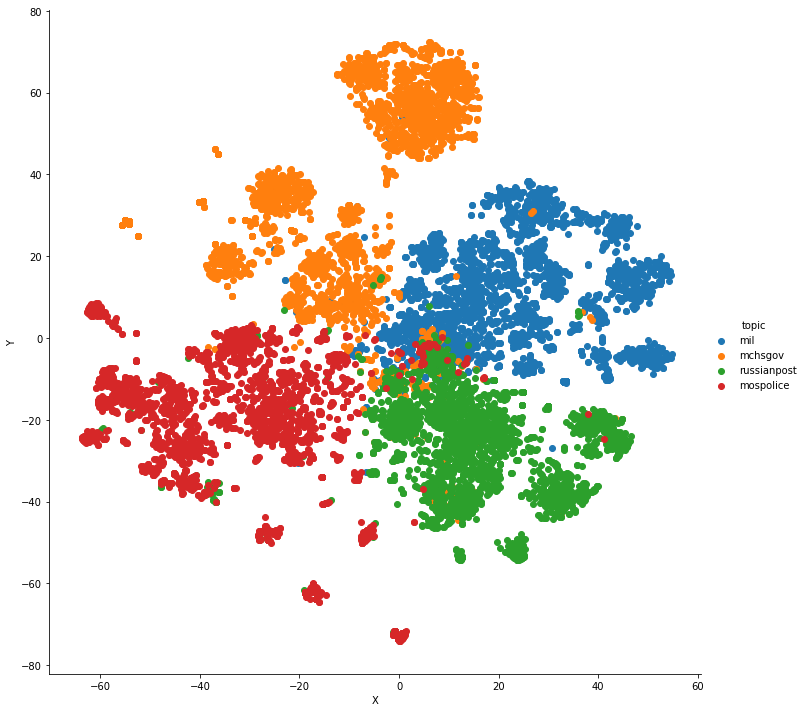

In [61]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : df.source})
sns.FacetGrid(vis_df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

## Задание 7 [4 балла]. Continious bag of words
Для baseline решения мы использовали обычное представление текста в виде мешка слов. Попробуйте использовать другие модели представления текста – например, в виде непрерывного мешка слов, то есть, в виде набора эмбеддингов. Для того, чтобы получить вектор текста попробуйте:
* усреднить все эмбеддинги слов, входящих в этот текст
* усреднить все эмбеддинги слов, входящих в этот текст с $tf-idf$ весами
* использовать любую модель эмбеддинга документа.

Используйте любую модель эмбеддингов по вашему вкусу. 


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

Сначала просто используем doc2vec.

In [62]:
#переводим данные в gensim формат
train_tagged = train.apply(
    lambda x: TaggedDocument(words=x['text_norm'].split(), tags=[x.source]), axis=1)
test_tagged = test.apply(
    lambda x: TaggedDocument(words=x['text_norm'].split(), tags=[x.source]), axis=1)

Модель Distributed Bag of Words

In [63]:
#размер ветора 300, строим словарь, обучаем в 30 эпох, можно еще раз перемешать

model_dbow = Doc2Vec(dm=0, vector_size=300)
model_dbow.build_vocab([x for x in train_tagged.values])

In [64]:
model_dbow.train(shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=30)

In [65]:
#собствеено получаем вектора для обучения
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [66]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [67]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [68]:
evaluation(y_test, y_pred)

              precision    recall  f1-score   support

     mchsgov       0.97      0.95      0.96       618
         mil       0.98      0.98      0.98       630
   mospolice       0.96      0.98      0.97       555
 russianpost       0.94      0.93      0.94       503

   micro avg       0.96      0.96      0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306


Accuracy =  0.9622723330442324


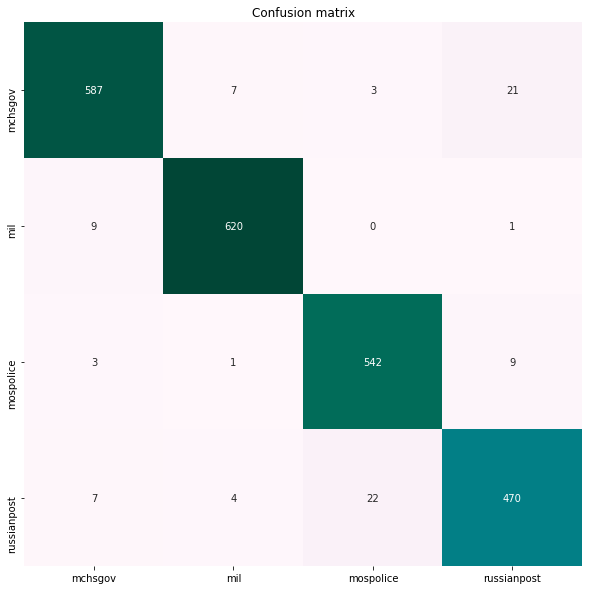

In [69]:
m = confusion_matrix(y_test, y_pred)

labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

DBOW + GradientBoostingClassifier дали хорошие результаты, но на 0.01 меньше бейслайна по всем метрикам. Попробуем Distributed Memory (DM).

In [70]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300)
model_dm.build_vocab([x for x in train_tagged.values])

In [71]:
model_dm.train(shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=30)

In [72]:
y_train, X_train = vec_for_learning(model_dm, train_tagged)
y_test, X_test = vec_for_learning(model_dm, test_tagged)

In [73]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [74]:
evaluation(y_test, y_pred)

              precision    recall  f1-score   support

     mchsgov       0.81      0.88      0.84       618
         mil       0.89      0.82      0.85       630
   mospolice       0.90      0.86      0.88       555
 russianpost       0.82      0.84      0.83       503

   micro avg       0.85      0.85      0.85      2306
   macro avg       0.85      0.85      0.85      2306
weighted avg       0.85      0.85      0.85      2306


Accuracy =  0.8516912402428447


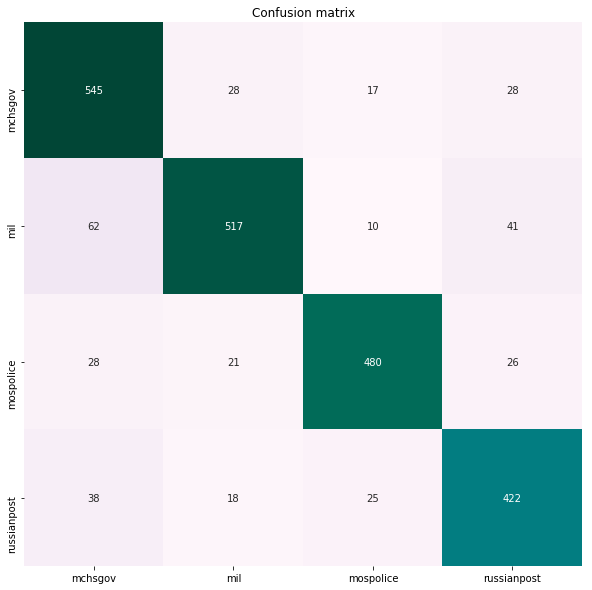

In [75]:
m = confusion_matrix(y_test, y_pred)

labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

DM справился похуже, теперь попробуем скомбинировать эти методы.

In [76]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dm])

In [77]:
y_train, X_train = vec_for_learning(new_model, train_tagged)
y_test, X_test = vec_for_learning(new_model, test_tagged)

In [78]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [79]:
evaluation(y_test, y_pred)

              precision    recall  f1-score   support

     mchsgov       0.97      0.95      0.96       618
         mil       0.98      0.98      0.98       630
   mospolice       0.96      0.97      0.96       555
 russianpost       0.93      0.94      0.93       503

   micro avg       0.96      0.96      0.96      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.96      0.96      0.96      2306


Accuracy =  0.9605377276669558


Результаты варьируются на +-0.01 по сравнению с просто DBOW.

Теперь попробуем использовать word2vec. Сначала с усреднением эмбеддингов входящих в текст слов. source: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [80]:
model = Word2Vec(train.text_norm, size=300)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

c:\python35\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [81]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec], axis = 0)
            for words in X
        ])

In [82]:
clf = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("clasifier", GradientBoostingClassifier())])

clf.fit(train.text_norm, train.source)

Pipeline(memory=None,
     steps=[('word2vec vectorizer', <__main__.MeanEmbeddingVectorizer object at 0x000001C3B827B898>), ('clasifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
        ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [83]:
predictions = clf.predict(test.text_norm)

In [84]:
evaluation(test.source, predictions)

              precision    recall  f1-score   support

     mchsgov       0.94      0.87      0.91       618
         mil       0.90      0.90      0.90       630
   mospolice       0.90      0.91      0.91       555
 russianpost       0.79      0.84      0.81       503

   micro avg       0.89      0.89      0.89      2306
   macro avg       0.88      0.88      0.88      2306
weighted avg       0.89      0.89      0.89      2306


Accuracy =  0.8850823937554206


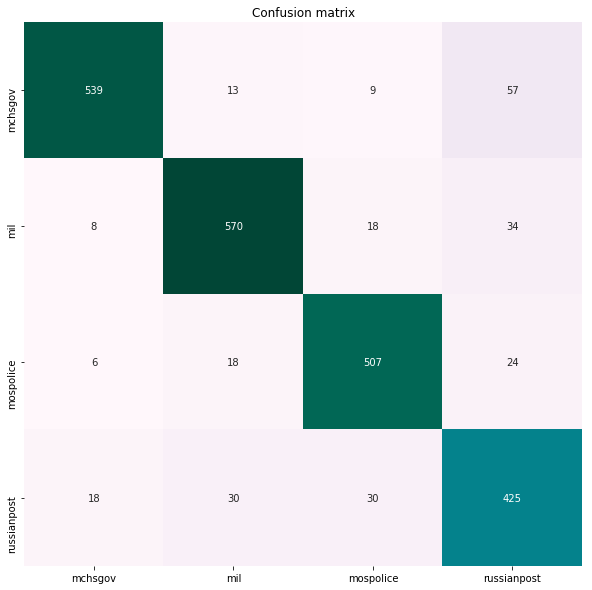

In [85]:
m = confusion_matrix(test.source, predictions)

labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Хуже, чем бейслайн и док2век, попробуем с tf-if взвешиванием.

In [86]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec], axis=0)
                for words in X
            ])

In [87]:
clf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("clasifier", GradientBoostingClassifier())])

clf.fit(train.text_norm, train.source)

Pipeline(memory=None,
     steps=[('word2vec vectorizer', <__main__.TfidfEmbeddingVectorizer object at 0x000001C3B80EC048>), ('clasifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
       ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [88]:
predictions = clf.predict(test.text_norm)

In [89]:
evaluation(test.source, predictions)

              precision    recall  f1-score   support

     mchsgov       0.94      0.87      0.90       618
         mil       0.89      0.89      0.89       630
   mospolice       0.88      0.89      0.89       555
 russianpost       0.77      0.82      0.79       503

   micro avg       0.87      0.87      0.87      2306
   macro avg       0.87      0.87      0.87      2306
weighted avg       0.87      0.87      0.87      2306


Accuracy =  0.870338248048569


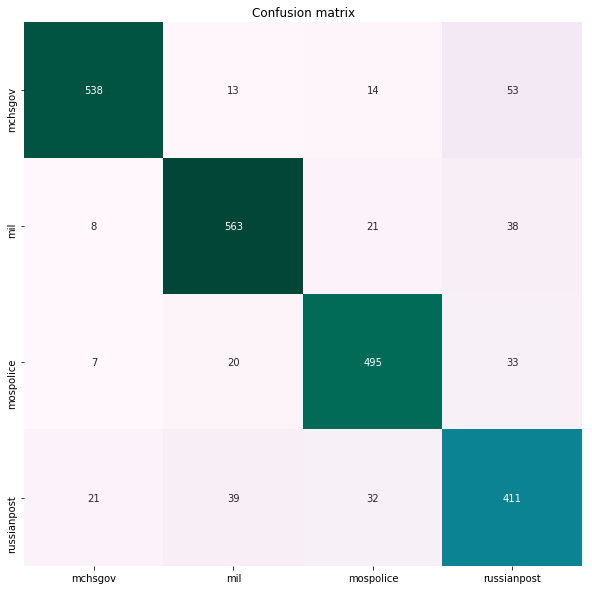

In [90]:
m = confusion_matrix(test.source, predictions)

labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Tf-idf особо не помог.

Теперь построим матрицу вручную.

In [91]:
#делаем словари индекс-слово, слово-индекс, получаем значения скипграм, получаем разреженную матрицу

def build_index(texts):
    word2index = dict()
    word_counts = Counter()
    for text in texts:
        for word in text:
            word_counts[word] += 1
            if word not in word2index:
                word2index[word] = len(word2index)
    return {index:word for word, index in word2index.items()}, word2index


def build_skipgram_counts(texts, window=2):
    skipgram_counts = Counter()
    for text in texts:
        for id_fw, fw in enumerate(text):
            id_cw_min = max(0, id_fw - window)
            id_cw_max = min(len(text) - 1, id_fw + window)
            id_cws = [i for i in range(id_cw_min, id_cw_max + 1) if i != id_fw]
            for id_cw in id_cws:
                skipgram = (text[id_fw], text[id_cw])
                skipgram_counts[skipgram] += 1   
    return skipgram_counts

def build_count_matrix(texts, skipgram_counts, word2index):
    row_indices = []
    col_indices = []
    dat_values = []
    for (word_1, word_2), sg_count in skipgram_counts.items():
        row_indices.append(word2index[word_1])
        col_indices.append(word2index[word_2])
        dat_values.append(sg_count)
    return sparse.csr_matrix((dat_values, (row_indices, col_indices)))

In [92]:
texts = [text.split() for text in df.text_norm]

index2word, word2index = build_index(texts)
skipgram_counts = build_skipgram_counts(texts)
count_matrix = build_count_matrix(texts, skipgram_counts, word2index)

In [93]:
#достаем вектор из матрицы
def word_vector(word, matrix, word2index):
    index = word2index[word]
    if isinstance(matrix, sparse.csr_matrix):
        word_ = matrix.getrow(index)
    else:
        word_ = matrix[index:index + 1, :]
    return word_

In [94]:
#применяем svd для снижения размерности
def factorize_matrix(matrix, method='svd', k=300):
    if method == 'svd':
        try:
            u, s, vh = np.linalg.svd(matrix)
            return u
        except np.linalg.LinAlgError:
            _matrix = matrix.asfptype()
            u, s, vt = sparse.linalg.svds(_matrix, k=k)
            return u
    else:
        raise NotImplementedError

In [95]:
count_matrix = factorize_matrix(count_matrix)

In [96]:
#получаем непосредственно вектора для обучения
def get_matrix(sent, matrix, word2index):
    vector = np.zeros(shape=matrix.shape[1])
    counter = 0
    for word in sent:
        if word in word2index: 
            try:
                vector = np.add(vector, word_vector(word, matrix, word2index))
                counter += 1
            except KeyError:
                pass
    if counter == 0:
        return vector.squeeze()
    return (vector / counter).squeeze()

In [97]:
train_vectors = [get_matrix(text.split(), count_matrix, word2index) for text in train.text_norm]
test_vectors = [get_matrix(text.split(), count_matrix, word2index) for text in test.text_norm]

In [98]:
clf = GradientBoostingClassifier()
clf.fit(train_vectors, train.source)
predictions = clf.predict(test_vectors)

In [99]:
evaluation(test.source, predictions)

              precision    recall  f1-score   support

     mchsgov       0.97      0.93      0.95       618
         mil       0.95      0.97      0.96       630
   mospolice       0.95      0.97      0.96       555
 russianpost       0.92      0.93      0.93       503

   micro avg       0.95      0.95      0.95      2306
   macro avg       0.95      0.95      0.95      2306
weighted avg       0.95      0.95      0.95      2306


Accuracy =  0.9509973980919341


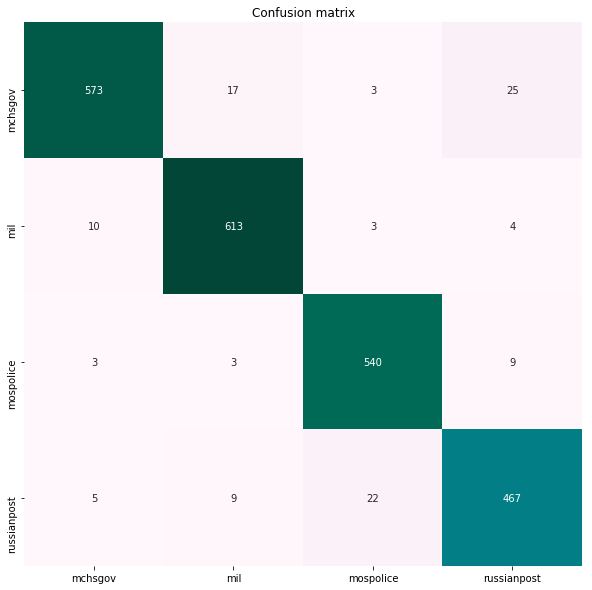

In [100]:
m = confusion_matrix(test.source, predictions)

labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

Результаты превзошли вордтувек, но не превзошли бейслайн.

## Задание 8 [2 балла]. fastText

Используйте ```fastText``` в режиме классификации. Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [7]:
ftdata = df[['source', 'text_norm']]
ftdata['source'] = ['__label__' + s for s in ftdata['source']]
ftdata.head()

c:\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,source,text_norm
0,__label__mil,начальник главный оперативный управление генер...
1,__label__mil,артиллерийский подразделение общевойсковой объ...
2,__label__mil,подразделение морской пехота каспийский флотил...
3,__label__mil,команда всеармейский этап конкурс арми-2018 та...
4,__label__mil,большой учебно-методический командирский сбор ...


In [8]:
ftdata = shuffle(ftdata)

fttrain, fttest = train_test_split(ftdata, test_size=0.2)
fttrain.tail()

fttrain = fttrain.to_csv('fttrain.txt', encoding = 'utf-8')
fttest = fttest.to_csv('fttest.txt', encoding = 'utf-8')

In [9]:
classifier = ft.supervised('fttrain.txt', 'model', encoding = 'utf-8')

In [ ]:
from gensim.models.wrappers import FastText 

model = FastText.load_fasttext_format('model.bin', encoding='utf-8')

In [22]:
#result = model.test('fttest.txt')
result = classifier.test('fttest.txt')

In [23]:
print ('P@1:', result.precision)
print ('R@1:', result.recall)
print ('Number of examples:', result.nexamples)

P@1: nan
R@1: nan
Number of examples: 0


In [ ]:
vectors = KeyedVectors.load_word2vec_format('model.bin', encoding = 'utf-8')

In [ ]:
def get_vector(sent, model):
    vector = np.zeros(shape=model.vector_size)
    counter = 0
    for word in sent:
        if word in model.vocab: 
            try:
                vector = np.add(vector, model[word])
                counter += 1
            except KeyError:
                pass
    if counter == 0:
        return vector
    return vector / counter

In [ ]:
train_vectors = [get_vector(text.split(' '), vectors) for text in train.text_norm]
test_vectors = [get_vector(text.split(' '), vectors) for text in test.text_norm]

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(train_vectors, train.source)
predictions = clf.predict(test_vectors)

In [ ]:
evaluation(test.source, predictions)

In [ ]:
m = confusion_matrix(test.source, predictions)

labels = clf.classes_
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

## Конец
Подведите итоги и проведите сравнение всех использованных методов. Какой из них показался вам лучше и почему?

Для решения задачи классификации на предоставленных данных оказалось достаточно бейслайнового решения. Даже подход, основанный на правилах уже дал приемлемый результат. Все дальнейшие методы не улучшали показатели, а если и получались примерно равными бейслайну, то только в результате многочисленных экспериментов. Хотя в простом пайплайне градиентный бустинг давал результаты чуть хуже, чем стохастический градиент, первый оказался намного более эффективен в тех методах, где значения метрик получались сначала очень низкими. Также удивили показатели doc2vec и то, что тф-идф взвешивание не помогло при использовании word2vec с усреднением.